In [1]:
"""
To make sure the fusion decomposition works
up to the part where we would stitch the sublimbs together into one limb


"""

'\nTo make sure the fusion decomposition works\nup to the part where we would stitch the sublimbs together into one limb\n\n\n'

In [2]:
from os import sys
sys.path.append("/meshAfterParty/")

In [3]:
import skeleton_utils as sk
import soma_extraction_utils as sm
import trimesh_utils as tu
import trimesh
import numpy_utils as nu
import numpy as np
from importlib import reload
import networkx as nx
import time
import compartment_utils as cu
import networkx_utils as xu
import matplotlib_utils as mu
import neuron_utils as nru

#importing at the bottom so don't get any conflicts
import itertools
from tqdm_utils import tqdm

#for meshparty preprocessing
import meshparty_skeletonize as m_sk
import general_utils as gu
import compartment_utils as cu
from meshparty import trimesh_io
from copy import deepcopy


from neuron_utils import *


# Loading the Neuron

In [4]:
import trimesh_utils as tu
curent_neuron = tu.load_mesh_no_processing("/notebooks/test_neurons/Segmentation_2/864691135579649476_large_axon_cloud_2.off")
segment_id = 864691135579649476
description = "large_axon_cloud_2"

In [5]:
import neuron_visualizations as nviz
nviz.plot_objects(main_mesh=curent_neuron)

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


# Setting the Arguments that would be present inside a preprocessing function call

In [6]:
#predefined arguments for the Neuron constructor

decomposition_type="meshafterparty"
mesh_correspondence="meshparty" #meshafterparty_adaptive
distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
meshparty_adaptive_correspondence_after_creation=False
suppress_preprocessing_print=True
computed_attribute_dict=None
somas = None
branch_skeleton_data=None
combine_close_skeleton_nodes = True
combine_close_skeleton_nodes_threshold=700
ignore_warnings=True
suppress_output=False
calculate_spines=True
widths_to_calculate=["no_spine_median_mesh_center",
                "no_spine_mean_mesh_center"]
fill_hole_size=2000

In [7]:
#arguments for the preprocess neuron
mesh = curent_neuron
segment_id=segment_id
description=description

sig_th_initial_split=15 #for significant splitting meshes in the intial mesh split
limb_threshold = 2000 #the mesh faces threshold for a mesh to be qualified as a limb (otherwise too small)
filter_end_node_length=4001 #used in cleaning the skeleton during skeletonizations
return_no_somas = False

decomposition_type=decomposition_type
mesh_correspondence=mesh_correspondence
distance_by_mesh_center=distance_by_mesh_center
meshparty_segment_size =meshparty_segment_size
meshparty_n_surface_downsampling = meshparty_n_surface_downsampling
somas=somas
branch_skeleton_data=branch_skeleton_data
combine_close_skeleton_nodes = combine_close_skeleton_nodes
combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold

# Setting up the metadata

In [8]:
whole_processing_tiempo = time.time()


"""
Purpose: To process the mesh into a format that can be loaded into the neuron class
and used for higher order processing (how to visualize is included)

"""
if description is None:
    description = "no_description"
if segment_id is None:
    #pick a random segment id
    segment_id = np.random.randint(100000000)
    print(f"picking a random 7 digit segment id: {segment_id}")
    description += "_random_id"


if mesh is None:
    if current_mesh_file is None:
        raise Exception("No mesh or mesh_file file were given")
    else:
        current_neuron = trimesh.load_mesh(current_mesh_file)
else:
    current_neuron = mesh

# ************************ Phase A: Soma and Limb Identification ********************************

In [9]:
# --- 1) Doing the soma detection
if somas is None:
    soma_mesh_list,run_time,total_soma_list_sdf = sm.extract_soma_center(segment_id,
                                             current_neuron.vertices,
                                             current_neuron.faces)
else:
    soma_mesh_list,run_time,total_soma_list_sdf = somas

# geting the soma centers
if len(soma_mesh_list) <= 0:
    print(f"**** No Somas Found for Mesh {segment_id} so just one mesh")
    soma_mesh_list_centers = []
    if return_no_somas:
        return_value= soma_mesh_list_centers
    raise Exception("Processing of No Somas is not yet implemented yet")
else:
    #compute the soma centers
    print(f"Soma List = {soma_mesh_list}")

    soma_mesh_list_centers = sm.find_soma_centroids(soma_mesh_list)
    print(f"soma_mesh_list_centers = {soma_mesh_list_centers}")

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 15000.0 
large_mesh_threshold_inner = 10000.0 
soma_size_threshold = 937.5 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
xvfb-run -n 4718 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/864691135579649476/neuron_864691135579649476.off -o /notebooks/Platinum_Decomp_Fusion/864691135579649476/neuron_864691135579649476_decimated.off -s /notebooks/Platinum_Decomp_Fusion/864691135579649476/decimation_meshlab_25217092.mls
Total found significant pieces before Poisson = [<trimesh.Trimesh(vertices.shape=(202092, 3), faces.shape=(400410, 3))>]
----- working on large mesh #0: <trimesh.Trimesh(vertices.shape=(202092, 3), faces.shape=(400410, 3))>
pre_largest_mesh_path = /notebooks/Platinum_Decomp_Fusion/864691135579649476/neuron_864691135579649476_decimated_largest_piece.off
xvfb-run -n 2729 -s "-screen 0 800x600x24" meshlabserver $@  -i /noteb

In [10]:
#--- 2) getting the soma submeshes that are connected to each soma and identifiying those that aren't (and eliminating any mesh pieces inside the soma)

main_mesh_total = current_neuron


#finding the mesh pieces that contain the soma
#splitting the current neuron into distinct pieces
split_meshes = tu.split_significant_pieces(
                            main_mesh_total,
                            significance_threshold=sig_th_initial_split,
                            print_flag=False)

print(f"# total split meshes = {len(split_meshes)}")


#returns the index of the split_meshes index that contains each soma    
containing_mesh_indices = sm.find_soma_centroid_containing_meshes(soma_mesh_list,
                                        split_meshes)

# filtering away any of the inside floating pieces: 
non_soma_touching_meshes = [m for i,m in enumerate(split_meshes)
                 if i not in list(containing_mesh_indices.values())]


#Adding the step that will filter away any pieces that are inside the soma
if len(non_soma_touching_meshes) > 0 and len(soma_mesh_list) > 0:
    """
    *** want to save these pieces that are inside of the soma***
    """

    non_soma_touching_meshes,inside_pieces = sm.filter_away_inside_soma_pieces(soma_mesh_list,non_soma_touching_meshes,
                                    significance_threshold=sig_th_initial_split,
                                    return_inside_pieces = True)                                                      


split_meshes # the meshes of the original mesh
containing_mesh_indices #the mapping of each soma centroid to the correct split mesh
soma_containing_meshes = sm.grouping_containing_mesh_indices(containing_mesh_indices)

soma_touching_meshes = [split_meshes[k] for k in soma_containing_meshes.keys()]


#     print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")
#     print(f"# of inside pieces = {len(inside_pieces)}")
print(f"# of soma containing seperate meshes = {len(soma_touching_meshes)}")
print(f"meshes with somas = {soma_containing_meshes}")






# total split meshes = 55
There were 54 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0]}


In [11]:
tu = reload(tu)
#--- 3)  Soma Extraction was great (but it wasn't the original soma faces), so now need to get the original soma faces and the original non-soma faces of original pieces

#     sk.graph_skeleton_and_mesh(other_meshes=[soma_meshes])

"""
for each soma touching mesh get the following:
1) original soma meshes
2) significant mesh pieces touching these somas
3) The soma connectivity to each of the significant mesh pieces
-- later will just translate the 


Process: 

1) Final all soma faces (through soma extraction and then soma original faces function)
2) Subtact all soma faces from original mesh
3) Find all significant mesh pieces
4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all
   the available somas
Conclusion: Will have connectivity map


"""

soma_touching_mesh_data = dict()

for z,(mesh_idx, soma_idxes) in enumerate(soma_containing_meshes.items()):
    soma_touching_mesh_data[z] = dict()
    print(f"\n\n----Working on soma-containing mesh piece {z}----")

    #1) Final all soma faces (through soma extraction and then soma original faces function)
    current_mesh = split_meshes[mesh_idx]

    current_soma_mesh_list = [soma_mesh_list[k] for k in soma_idxes]

    current_time = time.time()
    mesh_pieces_without_soma = sm.subtract_soma(current_soma_mesh_list,current_mesh,
                                                significance_threshold=250)
    print(f"Total time for Subtract Soam = {time.time() - current_time}")
    current_time = time.time()

    mesh_pieces_without_soma_stacked = tu.combine_meshes(mesh_pieces_without_soma)

    # find the original soma faces of mesh
    soma_faces = tu.original_mesh_faces_map(current_mesh,mesh_pieces_without_soma_stacked,matching=False)
    print(f"Total time for Original_mesh_faces_map for mesh_pieces without soma= {time.time() - current_time}")
    current_time = time.time()
    soma_meshes = current_mesh.submesh([soma_faces],append=True,repair=False)

    # finding the non-soma original faces
    non_soma_faces = tu.original_mesh_faces_map(current_mesh,soma_meshes,matching=False)
    non_soma_stacked_mesh = current_mesh.submesh([non_soma_faces],append=True,repair=False)

    print(f"Total time for Original_mesh_faces_map for somas= {time.time() - current_time}")
    current_time = time.time()

    # 3) Find all significant mesh pieces
    sig_non_soma_pieces,insignificant_limbs = tu.split_significant_pieces(non_soma_stacked_mesh,significance_threshold=limb_threshold,
                                                     return_insignificant_pieces=True)

    print(f"Total time for sig_non_soma_pieces= {time.time() - current_time}")
    current_time = time.time()

    soma_touching_mesh_data[z]["branch_meshes"] = sig_non_soma_pieces

    #4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all the available somas
    # get all the seperate mesh faces

    #How to seperate the mesh faces
    seperate_soma_meshes,soma_face_components = tu.split(soma_meshes,only_watertight=False)
    #take the top largest ones depending how many were originally in the soma list
    seperate_soma_meshes = seperate_soma_meshes[:len(soma_mesh_list)]
    soma_face_components = soma_face_components[:len(soma_mesh_list)]

    soma_touching_mesh_data[z]["soma_meshes"] = seperate_soma_meshes

    print(f"Total time for split= {time.time() - current_time}")
    current_time = time.time()



    soma_to_piece_connectivity = dict()
    soma_to_piece_touching_vertices = dict()
    soma_to_piece_touching_vertices_idx = dict()
    limb_root_nodes = dict()
    
    m_vert_graph = tu.mesh_vertex_graph(current_mesh)
    
    for i,curr_soma in enumerate(seperate_soma_meshes):
        (connected_mesh_pieces,
         connected_mesh_pieces_vertices,
         connected_mesh_pieces_vertices_idx) = tu.mesh_pieces_connectivity(
                        main_mesh=current_mesh,
                        central_piece=curr_soma,
                        periphery_pieces = sig_non_soma_pieces,
                        return_vertices = True,
                        return_vertices_idx=True)
        #print(f"soma {i}: connected_mesh_pieces = {connected_mesh_pieces}")
        soma_to_piece_connectivity[i] = connected_mesh_pieces

        soma_to_piece_touching_vertices[i] = dict()
        for piece_index,piece_idx in enumerate(connected_mesh_pieces):
            limb_root_nodes[piece_idx] = connected_mesh_pieces_vertices[piece_index][0]
            
            """ Old way of finding vertex connected components on a mesh without trimesh function
            #find the number of touching groups and save those 
            soma_touching_graph = m_vert_graph.subgraph(connected_mesh_pieces_vertices_idx[piece_index])
            soma_con_comp = [current_mesh.vertices[np.array(list(k)).astype("int")] for k in list(nx.connected_components(soma_touching_graph))]
            soma_to_piece_touching_vertices[i][piece_idx] = soma_con_comp
            """
            
            soma_to_piece_touching_vertices[i][piece_idx] = tu.split_vertex_list_into_connected_components(
                                                vertex_indices_list=connected_mesh_pieces_vertices_idx[piece_index],
                                                mesh=current_mesh, 
                                                vertex_graph=m_vert_graph, 
                                                return_coordinates=True
                                               )
            
            
            
            

#         border_debug = False
#         if border_debug:
#             print(f"soma_to_piece_connectivity = {soma_to_piece_connectivity}")
#             print(f"soma_to_piece_touching_vertices = {soma_to_piece_touching_vertices}")


    print(f"Total time for mesh_pieces_connectivity= {time.time() - current_time}")

    soma_touching_mesh_data[z]["soma_to_piece_connectivity"] = soma_to_piece_connectivity

print(f"# of insignificant_limbs = {len(insignificant_limbs)} with trimesh : {insignificant_limbs}")



# Lets have an alert if there was more than one soma disconnected meshes
if len(soma_touching_mesh_data.keys()) > 1:
    raise Exception("More than 1 disconnected meshes that contain somas")

current_mesh_data = soma_touching_mesh_data
soma_containing_idx = 0

#doing inversion of the connectivity and touching vertices
piece_to_soma_touching_vertices = gu.flip_key_orders_for_dict(soma_to_piece_touching_vertices)


# ****Soma Touching mesh Data has the branches and the connectivity (So this is where you end up skipping if you don't have somas)***



----Working on soma-containing mesh piece 0----

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(525507, 3), faces.shape=(1048083, 3))>, <trimesh.Trimesh(vertices.shape=(117276, 3), faces.shape=(233741, 3))>, <trimesh.Trimesh(vertices.shape=(59339, 3), faces.shape=(118225, 3))>, <trimesh.Trimesh(vertices.shape=(49526, 3), faces.shape=(98795, 3))>, <trimesh.Trimesh(vertices.shape=(30123, 3), faces.shape=(60166, 3))>]
There were 5 pieces found after size threshold
mesh pieces in subtact soma AFTER the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(525507, 3), faces.shape=(1048083, 3))>, <trimesh.Trimesh(vertices.shape=(117276, 3), faces.shape=(233741, 3))>, <trimesh.Trimesh(vertices.shape=(59339, 3), faces.shape=(118225, 3))>, <trimesh.Trimesh(vertices.shape=(49526, 3), faces.shape=(98795, 3))>, <trimesh.Trimesh(vertices.shape=(30123, 3), faces.shape=(60166, 3))>]
Total Time for soma mesh cancellati

# Process that will start for each limb

In [12]:
sk = reload(sk)
tu = reload(tu)
cu = reload(cu)
m_sk = reload(m_sk)
pre = reload(pre)
xu = reload(xu)
nu = reload(nu)
gu = reload(gu)


proper_time = time.time()

#The containers that will hold the final data for the preprocessed neuron
limb_correspondence=dict()
limb_network_stating_info = dict()

# ---------- Part A: skeletonization and mesh decomposition --------- #
skeleton_time = time.time()

for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
    
    #Arguments to pass to the specific function (when working with a limb)
    soma_touching_vertices_dict = piece_to_soma_touching_vertices[curr_limb_idx]
    
#     if curr_limb_idx != 10:
#         continue
    
    curr_limb_time = time.time()
    print(f"\n\n----- Working on Proper Limb # {curr_limb_idx} ---------")
    

    limb_correspondence_individual,network_starting_info = pre.preprocess_limb(mesh=limb_mesh_mparty,
                   soma_touching_vertices_dict = soma_touching_vertices_dict,
                   return_concept_network = False, 
                   return_concept_network_starting_info=True,
                   width_threshold_MAP=500,
                   size_threshold_MAP=2000,
                   surface_reconstruction_size=1000,                                                            
                   )
    #Storing all of the data to be sent to 
    
    limb_correspondence[curr_limb_idx] = limb_correspondence_individual
    limb_network_stating_info[curr_limb_idx] = network_starting_info
    
#     raise Exception("Done with #10")
    
    
print(f"Total time for Skeletonization and Mesh Correspondence = {time.time() - skeleton_time}")

pre=reload(pre)
neuron=reload(neuron)
nru = reload(nru)
# ---------- Part B: Stitching on floating pieces --------- #
floating_stitching_time = time.time()

limb_correspondence_with_floating_pieces = pre.attach_floating_pieces_to_limb_correspondence(
        limb_correspondence,
        floating_meshes=non_soma_touching_meshes,
        floating_piece_face_threshold = 600,
        max_stitch_distance=8000,
        distance_to_move_point_threshold = 4000,
        verbose = False)



print(f"Total time for stitching floating pieces = {time.time() - floating_stitching_time}")





# ---------- Part C: Computing Concept Networks --------- #
concept_network_time = time.time()

limb_concept_networks=dict()
limb_labels=dict()

for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
    limb_to_soma_concept_networks = pre.calculate_limb_concept_networks(limb_correspondence_with_floating_pieces[curr_limb_idx],
                                                                        run_concept_network_checks=True,
                                                                       **limb_network_stating_info[curr_limb_idx])   



    limb_concept_networks[curr_limb_idx] = limb_to_soma_concept_networks
    limb_labels[curr_limb_idx]= "Unlabeled"
    
print(f"Total time for Concept Networks = {time.time() - concept_network_time}")





preprocessed_data= dict(
    soma_meshes = current_mesh_data[0]["soma_meshes"],
    soma_to_piece_connectivity = current_mesh_data[0]["soma_to_piece_connectivity"],
    soma_sdfs = total_soma_list_sdf,
    insignificant_limbs=insignificant_limbs,
    non_soma_touching_meshes=non_soma_touching_meshes,
    inside_pieces=inside_pieces,
    limb_correspondence=limb_correspondence_with_floating_pieces,
    limb_concept_networks=limb_concept_networks,
    limb_network_stating_info=limb_network_stating_info,
    limb_labels=limb_labels,
    limb_meshes=current_mesh_data[0]["branch_meshes"],
    )

    

print(f"Total time for all limb decomps = {time.time() - proper_time}")

#864049.29563888 1004924.982468    884750.28428994

neuron_obj = neuron.Neuron(
                mesh=curent_neuron,
                 segment_id=segment_id,
                 description=description,
                 preprocessed_data=preprocessed_data,
#                  decomposition_type="meshafterparty",
#                  mesh_correspondence="meshparty", #meshafterparty_adaptive
#                  distance_by_mesh_center=True, #how the distance is calculated for mesh correspondence
#                  meshparty_segment_size = 0,
#                  meshparty_n_surface_downsampling = 0,
#                  meshparty_adaptive_correspondence_after_creation=False,
#                 suppress_preprocessing_print=True,
#                  computed_attribute_dict=None,
#                  somas = None,
#                  branch_skeleton_data=None,
#                  combine_close_skeleton_nodes = True,
#                 combine_close_skeleton_nodes_threshold=700,
    
    
                ignore_warnings=True,
                suppress_output=False,
                calculate_spines=True,
                widths_to_calculate=["no_spine_median_mesh_center"]
                )



----- Working on Proper Limb # 0 ---------
Time for preparing soma vertices and root: 8.58306884765625e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [03:19<00:00, 199.10s/it]

Time for 1st pass MP skeletonization: 204.83004307746887


/meshAfterParty/meshparty_skeletonize.py:888: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:921: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in new_segments])


branches_touching_root = [586]


/meshAfterParty/meshparty_skeletonize.py:949: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array(new_segment_branches)


length of Graph = 137882
Working on path [1378. 1386. 1395. 1405. 1414. 1425. 1434. 1437.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
Working on path [3556. 3563. 3571. 3579. 3588. 3608. 3626. 3630.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
Working on path [3658. 3669. 3676. 3686. 3693. 3696.]
path_degrees = [3, 2, 2, 2, 2, 3]
Working on path [5447. 5462. 5478. 5494. 5515. 5535. 5536.]
path_degrees = [3, 2, 2, 2, 2, 2, 3]
Working on path [14558. 14570. 14582. 14596. 14602.]
path_degrees = [3, 2, 2, 2, 3]
Working on path [15312. 15347. 15395. 15451. 15472. 15476.]
path_degrees = [3, 2, 2, 2, 2, 3]
Working on path [20617. 20635. 20638.]
path_degrees = [3, 2, 3]
Working on path [25614. 25652. 25664.]
path_degrees = [3, 2, 3]
Working on path [29738. 29821. 29890. 29973. 30053. 30110. 30158. 30174.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
Working on path [29743. 29787. 29815.]
path_degrees = [3, 2, 3]
Working on path [35904. 35965. 36018. 36053.]
path_degrees = [3, 2, 2, 3]
Working on path [452

/meshAfterParty/meshparty_skeletonize.py:974: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 586, len(kept_branches_idx) = 548
empty_indices % = 0.0
 conflict_indices % = 0.011529958034694882


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



AFTER face_lookup_resolved_test


/meshAfterParty/trimesh_utils.py:972: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


Decomposing first pass: 252.2024006843567
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [222, 63, 136]
mesh_large_connectivity: 1.7193591594696045
Finding MAP candidates connected components: 0.00017642974853515625
Divinding into MP and MAP pieces: 2.86102294921875e-06
Total time for MAP sublimb processing 5.245208740234375e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 0.0005397796630859375
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 8.852534770965576
sbv[0].reshape(-1,3) = [[762329.9 827704.6 900598.4]]
closest_sk_pt_coord BEFORE = [762806.21098452 827772.26837448 899923.52448837]
current_skeleton.shape = (137717, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [762

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.65s/it]

Time for 1st pass MP skeletonization: 6.032905340194702
branches_touching_root = [64]


/meshAfterParty/meshparty_skeletonize.py:888: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:921: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in new_segments])
/meshAfterParty/meshparty_skeletonize.py:949: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

length of Graph = 15555


/meshAfterParty/meshparty_skeletonize.py:974: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 64, len(kept_branches_idx) = 65
empty_indices % = 0.0
 conflict_indices % = 0.011179040048600802


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



AFTER face_lookup_resolved_test



Decomposing first pass: 11.520799160003662
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [3569, 1227, 1909, 3707, 4797, 998, 5177, 1225, 1419, 2136, 817, 3658, 1324, 1671, 3338, 1485, 939, 2750, 2651, 3399, 1002, 2067, 2704, 4158, 8422]


/meshAfterParty/trimesh_utils.py:972: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


mesh_large_connectivity: 0.479633092880249
Finding MAP candidates connected components: 0.0003674030303955078
len(filtered_pieces) = 2
skeleton_connectivity_MP : 0.589707612991333
Grouping MP Sublimbs by Graph: 0.10833740234375
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.006790876388549805
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 9357 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_120576.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 1574 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/P


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.07352471351623535
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 58.08939027786255
Checking connected components after removing cycles
Total time for mesh KDTree = 0.45321130752563477
sbv[0].reshape(-1,3) = [[761881.4 821452.4 898319.6]]
closest_sk_pt_coord BEFORE = [761076. 821003. 900404.]
current_skeleton.shape = (611, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4807.018282402381
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [761076. 821003. 900404.]
Adding new branch to skeleton
border_average_coordinate = [761272.55172414 821104.68068966 900421.79172414]
endpoints_must_keep = {0: array([[761272.55172414, 821104.68068966, 900421.79172414]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.7199122905731201
filter_end_node_length =


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (591, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 59.272650718688965
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 14.526477813720703
mesh_correspondence_first_pass: 14.526507377624512
Limb decomposed into 17 branches
divided_skeleton_graph_recovered = (591, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (591, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (16, 17)
empty_indices % = 0.06189049046191903
 conflict_indices % = 0.0343148914577486



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 76.65554666519165
correspondence_1_to_1: 2.849370002746582
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.004579782485961914
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 2991 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_971355.mls
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 1595 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_77969.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_77969_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_950516.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/neuron_7


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.02187371253967285
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 8.539846181869507
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.0016942024230957031
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (23, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 8.585906744003296
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 0.30329036712646484
mesh_correspondence_first_pass: 0.30332350730895996
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (23, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (23, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.06386066763425254
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 8.978513956069946
correspondence_1_to_1: 0.08447265625
Total time for MAP sublimb processing 85.63426852226257
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.00513148307800293
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.004300117492675781
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0033054351806640625
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.004817962646484375
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.006167411804199219
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.002932310104370117
Do Not Need to Fix MP Decompositi

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04104969945755754
 conflict_indices % = 0.008723061134730977



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [727020.79536677 834553.3166796  903550.30158262]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [194, 196.0]
Found winning edge: [477, 478.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.012539184952978056
 conflict_indices % = 0.014458447955984902



AFTER face_lookup_resolved_test



 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [760550.92312001 809621.34022113 866247.10268257]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [12]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [134, 135.0]
Found winning edge: [479, 480.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03381600996863318
 conflict_indices % = 0.0069608559274695996



AFTER face_lookup_resolved_test



 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [761007.90625476 810714.10361878 885840.89728417]
MP_branches_with_stitch_point = [2]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 7347.691100456776
MAP_branches_with_stitch_point = [12]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [578, 579.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05355183261394396
 conflict_indices % = 0.012071109810520154



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [733275.22308234 827653.38622258 906644.66824658]
MP_branches_with_stitch_point = [0, 3]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [209, 210.0]
Found winning edge: [44, 45.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08483290488431877
 conflict_indices % = 0.002713510425592688



AFTER face_lookup_resolved_test



 Finished with (4, 0) 




---- Working on (5, 0) connection-----
winning_vertex = [781392.65413376 790526.64366583 898896.68536397]
MP_branches_with_stitch_point = [2, 5]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [14]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [129, 131.0]
Found winning edge: [20, 21.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.007368510205810113
 conflict_indices % = 0.015245193529262301



AFTER face_lookup_resolved_test



 Finished with (5, 0) 




---- Working on (6, 0) connection-----
winning_vertex = [743542.53195346 789088.36415782 895722.00576884]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 5055.892571483253
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [15, 16.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.007548484496574149
 conflict_indices % = 0.030542329578446173



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (6, 0) 




---- Working on (7, 0) connection-----
winning_vertex = [748562.26024482 833816.96265614 892883.82609697]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 15438.560047167926
MAP_branches_with_stitch_point = [9]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [1038, 1039.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04779888609140154
 conflict_indices % = 0.009384298466468299



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (7, 0) 




---- Working on (8, 0) connection-----
winning_vertex = [726984.22707626 818362.03468552 894775.14999929]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [194, 195.0]
Found winning edge: [39, 40.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05178691840863115
 conflict_indices % = 0.029804450438300743



AFTER face_lookup_resolved_test



 Finished with (8, 0) 




---- Working on (9, 0) connection-----
winning_vertex = [754584.38397212 803166.86387221 899890.40566143]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6737.42495778963
MAP_branches_with_stitch_point = [19]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [913, 914.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.010808835047778183
 conflict_indices % = 0.01963343950707535



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (9, 0) 




---- Working on (10, 0) connection-----
winning_vertex = [757553.78529777 836750.54027692 880394.22132879]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [20]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [390, 391.0]
Found winning edge: [62, 63.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.050259491942092324
 conflict_indices % = 0.01347537102795229



AFTER face_lookup_resolved_test



 Finished with (10, 0) 




---- Working on (11, 0) connection-----
winning_vertex = [740231.10488247 785614.45419518 893915.41820535]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [241, 242.0]
Found winning edge: [73, 74.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.057037457434733256
 conflict_indices % = 0.02227582292849035



AFTER face_lookup_resolved_test



 Finished with (11, 0) 




---- Working on (12, 0) connection-----
winning_vertex = [767590.57940162 802341.75131541 896750.95314933]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 9215.83368718907
MAP_branches_with_stitch_point = [14]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [173, 175.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04174166452387074
 conflict_indices % = 0.015256706951229965



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (12, 0) 




---- Working on (14, 0) connection-----
winning_vertex = [748155.44638776 831317.99979302 895881.04033632]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 12086.904578945083
MAP_branches_with_stitch_point = [9]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [558, 559.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.055631973101023996
 conflict_indices % = 0.02239034082225279



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (14, 0) 




---- Working on (15, 0) connection-----
winning_vertex = [766270.83719614 779856.18306205 912149.00885177]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [17]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [27, 28.0]
Found winning edge: [29, 30.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.014858841010401188
 conflict_indices % = 0.02557843345361919



AFTER face_lookup_resolved_test



 Finished with (15, 0) 




---- Working on (16, 0) connection-----
winning_vertex = [746972.56155425 814447.47053761 905270.95176734]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4915.807006777224
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [142, 143.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.016263940520446097
 conflict_indices % = 0.023234200743494422



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (16, 0) 




---- Working on (5, 1) connection-----
winning_vertex = [780111.25692005 780219.78814367 909916.20105484]
MP_branches_with_stitch_point = [1, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [23, 24.0]
Found winning edge: [23, 24.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04154302670623145
 conflict_indices % = 0.0036032217041119118



AFTER face_lookup_resolved_test



 Finished with (5, 1) 




---- Working on (13, 1) connection-----
winning_vertex = [778411.57977386 774305.64380926 919540.45018573]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [8, 10.0]
Found winning edge: [24, 25.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.025344180225281603
 conflict_indices % = 0.0023988318731748017



AFTER face_lookup_resolved_test



 Finished with (13, 1) 



Time for decomp of Limb = 153.0871922969818


----- Working on Proper Limb # 2 ---------
Time for preparing soma vertices and root: 5.245208740234375e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

Time for 1st pass MP skeletonization: 1.3914799690246582
branches_touching_root = [18]


/meshAfterParty/meshparty_skeletonize.py:888: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:921: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in new_segments])
/meshAfterParty/meshparty_skeletonize.py:949: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

length of Graph = 7313


/meshAfterParty/meshparty_skeletonize.py:974: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 18, len(kept_branches_idx) = 19
empty_indices % = 0.0
 conflict_indices % = 0.006758299851977162



AFTER face_lookup_resolved_test



Decomposing first pass: 5.14699912071228
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [1601, 523, 1056, 881, 4679, 4958, 17887, 704, 17879, 7209]
mesh_large_connectivity: 0.15375494956970215
Finding MAP candidates connected components: 0.0001811981201171875
len(filtered_pieces) = 1


/meshAfterParty/trimesh_utils.py:972: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


skeleton_connectivity_MP : 0.20256924629211426
Grouping MP Sublimbs by Graph: 0.033083200454711914
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.008278369903564453
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 6002 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_355445.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 311 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_40303.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_40303_fill_holes.off -s /notebooks/Pla


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.06275129318237305
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 22.02722454071045
Checking connected components after removing cycles
Total time for mesh KDTree = 0.3824284076690674
sbv[0].reshape(-1,3) = [[762556.8 822440.  916448.2]]
closest_sk_pt_coord BEFORE = [763141. 821771. 916590.]
current_skeleton.shape = (666, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 22713.226213500104
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [763141. 821771. 916590.]
Adding new branch to skeleton
border_average_coordinate = [763272.70545455 821767.84363636 916880.23454545]
endpoints_must_keep = {0: array([[763272.70545455, 821767.84363636, 916880.23454545]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.630225419998169
filter_end_node_length = 


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (639, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 23.214078664779663
Working on limb correspondence for #0 MAP piece


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



Total time for decomposition = 7.828097581863403
mesh_correspondence_first_pass: 7.8281261920928955
Limb decomposed into 9 branches
divided_skeleton_graph_recovered = (639, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (639, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (8, 9)
empty_indices % = 0.03797688969447688
 conflict_indices % = 0.016609442808093837



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 32.34821629524231
correspondence_1_to_1: 1.2976446151733398
Total time for MAP sublimb processing 32.34832429885864
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.002332925796508789
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0028595924377441406
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0028717517852783203
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.002885580062866211
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.0030357837677001953
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.002882719039916992
Do Not Need to Fix MP Dec

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.035674559033847135
 conflict_indices % = 0.008342602892102336



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [770880.25824902 818904.61185432 924030.38805037]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6423.4029346776415
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [8, 9.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.038434006937943944
 conflict_indices % = 0.01872143604427069



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [789064.16913206 829611.69359264 929546.42156537]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 334.2887972995805
Changing the stitch point becasue the distance to end or branch node was 334.2887972995805
New stitch point has degree 1
MAP_branches_with_stitch_point = [9]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [66, 67.0]
Found winning edge: [11, 12.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04211618257261411
 conflict_indices % = 0.014263485477178423



AFTER face_lookup_resolved_test



 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [745861.68683139 839525.57941105 919809.25740874]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [78, 79.0]
Found winning edge: [640, 641.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02332542058003922
 conflict_indices % = 0.02291258127773764



AFTER face_lookup_resolved_test



 Finished with (3, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [763723.5405064  821319.02973226 928086.59034039]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 730.4252186226869
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [109, 110.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05353564271399943
 conflict_indices % = 0.06097910105926138



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
winning_vertex = [748988.60948475 831174.45558618 931899.95774989]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4733.480182989899
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [664, 666.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04847057006025027
 conflict_indices % = 0.00521396570369226



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (5, 0) 



Time for decomp of Limb = 58.85165739059448


----- Working on Proper Limb # 3 ---------
Time for preparing soma vertices and root: 8.58306884765625e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

Time for 1st pass MP skeletonization: 1.182168960571289
branches_touching_root = [18]


/meshAfterParty/meshparty_skeletonize.py:888: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:921: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in new_segments])
/meshAfterParty/meshparty_skeletonize.py:949: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

length of Graph = 6698


/meshAfterParty/meshparty_skeletonize.py:974: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 18, len(kept_branches_idx) = 19
empty_indices % = 0.0
 conflict_indices % = 0.007885014423806872



AFTER face_lookup_resolved_test



Decomposing first pass: 3.8359084129333496
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [2851, 1397, 1286, 1257, 1784, 997, 1695, 3717]
mesh_large_connectivity: 0.0630636215209961
Finding MAP candidates connected components: 0.000148773193359375
len(filtered_pieces) = 1


/meshAfterParty/trimesh_utils.py:972: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


skeleton_connectivity_MP : 0.26328444480895996
Grouping MP Sublimbs by Graph: 0.04355025291442871
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.009712934494018555
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 2387 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_560817.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 2285 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_84439.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_84439_fill_holes.off -s /notebooks/Plati


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.031210899353027344
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 14.99911642074585
Checking connected components after removing cycles
Total time for mesh KDTree = 0.11889934539794922
sbv[0].reshape(-1,3) = [[767854.1 820099.9 903377.6]]
closest_sk_pt_coord BEFORE = [768890. 819926. 904756.]
current_skeleton.shape = (126, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [768890. 819926. 904756.]
skipping soma 0 because closest skeleton node was already end node
sbv[0].reshape(-1,3) = [[768537.  820233.8 905189.2]]
closest_sk_pt_coord BEFORE = [769606. 819872. 905673.]
current_skeleton.shape = (126, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1164.9413746901912
Changing the stitch point becasue the d


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (123, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 15.332730293273926
Working on limb correspondence for #0 MAP piece


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



Total time for decomposition = 1.2801258563995361
mesh_correspondence_first_pass: 1.2803337574005127
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (123, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (123, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08315536572343833
 conflict_indices % = 0.02729578216764549



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 17.237874031066895
correspondence_1_to_1: 0.6151111125946045
Total time for MAP sublimb processing 17.238197565078735
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.005987882614135742
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.005804300308227539
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.005856990814208984
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.004677534103393555
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.005308866500854492
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.005883216857910156
Do Not Need to Fix MP Deco

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0469056974459725
 conflict_indices % = 0.009135559921414538



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [785306.94510224 801564.94503813 907866.86140161]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [75, 76.0]
Found winning edge: [223, 225.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12129751768797217
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [810432.92265073 808445.08133985 905323.56184341]
MP_branches_with_stitch_point = [0, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [62, 63.0]
Found winning edge: [58, 59.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11573979068335727
 conflict_indices % = 0.0031807921198440388



AFTER face_lookup_resolved_test



 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [803573.54526733 810444.83800131 908885.75403793]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6070.423462617694
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [9, 10.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.010471881060116353
 conflict_indices % = 0.019521654815772463



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [776134.53491595 816499.87429979 912627.40564207]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 3470.8170834458992
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [321, 326.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06710430342815463
 conflict_indices % = 0.016695032012318665



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
winning_vertex = [784709.93134428 815649.4453334  914301.87386819]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 5316.314543356527
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [26, 27.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.033700322234156824
 conflict_indices % = 0.014232008592910848



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
winning_vertex = [782236.91459555 807463.45361873 911479.84644713]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 5257.490811451111
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [839, 840.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.047066408768536426
 conflict_indices % = 0.019858156028368795



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (6, 0) 



Time for decomp of Limb = 49.02259564399719


----- Working on Proper Limb # 4 ---------
Time for preparing soma vertices and root: 7.152557373046875e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

Time for 1st pass MP skeletonization: 0.6142945289611816
branches_touching_root = [3]


/meshAfterParty/meshparty_skeletonize.py:888: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:949: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array(new_segment_branches)


length of Graph = 3912


/meshAfterParty/meshparty_skeletonize.py:974: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)
/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])


max(kept_branches_idx) = 12, len(kept_branches_idx) = 13
empty_indices % = 0.0
 conflict_indices % = 0.007529169298274773



AFTER face_lookup_resolved_test



Decomposing first pass: 2.125131607055664
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [6701, 2534, 3565, 661, 3017]
mesh_large_connectivity: 0.03529953956604004
Finding MAP candidates connected components: 0.00012803077697753906
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.134049654006958


/meshAfterParty/trimesh_utils.py:972: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


Grouping MP Sublimbs by Graph: 0.023459196090698242
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.00455784797668457
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 1881 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_92367.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 9595 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_84413.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_84413_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_738694.mls
r


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.03510236740112305
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 15.519129753112793
Checking connected components after removing cycles
Total time for mesh KDTree = 0.12493157386779785
sbv[0].reshape(-1,3) = [[761916.3 818819.9 914693.3]]
closest_sk_pt_coord BEFORE = [761852. 818087. 914764.]
current_skeleton.shape = (196, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [761852. 818087. 914764.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[761852., 818087., 914764.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.21848177909851074
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[761852. 818087. 914764.]]
Number of end_nodes


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (192, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 17.16416049003601
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 2.3841686248779297
mesh_correspondence_first_pass: 2.3841969966888428
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (192, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (192, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.05473965287049399
 conflict_indices % = 0.029372496662216287



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 20.00788974761963
correspondence_1_to_1: 0.45473790168762207
Total time for MAP sublimb processing 20.007986068725586
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.002672433853149414
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0035080909729003906
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0037031173706054688
Do Not Need to Fix MP Decomposition 2 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [720197.58984619 806633.14032917 925293.5252599 ]
MP_branches_with_stitch_point = [1, 3]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 456.4570640972178
Changing the stitch point becasue the distance to end or branch node was 456.4570640972178
New stitch point has degree 1
MAP_branches_with_stitch_point = 

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08709432048681541
 conflict_indices % = 0.015593306288032455



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [754758.42129612 793005.44768678 921690.90403998]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [706, 707.0]
Found winning edge: [15, 16.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.056057249957403306
 conflict_indices % = 0.011160333958084852



AFTER face_lookup_resolved_test



 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [771256.7283625  801088.91553893 922456.39948323]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [115, 117.0]
Found winning edge: [22, 23.0]


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.025512554710896106
 conflict_indices % = 0.015376641326883206



AFTER face_lookup_resolved_test



 Finished with (2, 0) 



Time for decomp of Limb = 33.62888956069946
Total time for Skeletonization and Mesh Correspondence = 799.375851392746
Status of Main limb stitch point moved = False
Status of Main limb stitch point moved = False
Total time for stitching floating pieces = 16.452757358551025
Starting_edge inside branches_to_conept = [[762806.21098452 827772.26837448 899923.52448837]
 [767220.43743923 856429.16897937 895385.68814459]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [240]
printing out current edge:
[[762806.21098452 827772.26837448 899923.52448837]
 [767220.43743923 856429.16897937 895385.68814459]]
edge_endpoints_to_process was empty so exiting loop after 549 iterations
starting_node in concept map (that should match the starting edge) = 547
Total time for branches to concept conversion = 12.830400466918945

Done generating concept network 


recovered_touching_piece = [547]
Starting_edge inside branches_to_conept

Working on limb L0 branch 454
Working on limb L0 branch 167
Working on limb L0 branch 363
Working on limb L0 branch 451
Working on limb L0 branch 51
Working on limb L0 branch 75
Working on limb L0 branch 381
Working on limb L0 branch 86
Working on limb L0 branch 536
Working on limb L0 branch 129
Working on limb L0 branch 281
Working on limb L0 branch 1
Working on limb L0 branch 23
Working on limb L0 branch 96
Working on limb L0 branch 181
Working on limb L0 branch 144
Working on limb L0 branch 306
Working on limb L0 branch 33
Working on limb L0 branch 198
Working on limb L0 branch 184
Working on limb L0 branch 250
Working on limb L0 branch 62
Working on limb L0 branch 467
Working on limb L0 branch 103
Working on limb L0 branch 108
Working on limb L0 branch 41
Working on limb L0 branch 137
Working on limb L0 branch 453
Working on limb L0 branch 475
Working on limb L0 branch 166
Working on limb L0 branch 337
Working on limb L0 branch 362
Working on limb L0 branch 535
Working on limb L0 b

Working on limb L0 branch 463
Working on limb L0 branch 121
Working on limb L0 branch 125
Working on limb L0 branch 459
Working on limb L0 branch 282
Working on limb L0 branch 503
Working on limb L0 branch 239
Working on limb L0 branch 251
Working on limb L0 branch 219
Working on limb L0 branch 512
Working on limb L0 branch 28
Working on limb L0 branch 373
Working on limb L0 branch 76
Working on limb L0 branch 430
Working on limb L0 branch 515
Working on limb L0 branch 403
Working on limb L0 branch 483
Working on limb L0 branch 193
Working on limb L0 branch 353
Working on limb L0 branch 278
Working on limb L0 branch 357
Working on limb L0 branch 397
Working on limb L0 branch 259
Working on limb L0 branch 448
Working on limb L0 branch 292
Working on limb L0 branch 443
Working on limb L0 branch 376
Working on limb L0 branch 440
Working on limb L0 branch 407
Working on limb L0 branch 520
Working on limb L0 branch 132
Working on limb L0 branch 298
Working on limb L0 branch 45
Working on li

Working on limb L1 branch 51
Working on limb L1 branch 52
Working on limb L1 branch 27
Working on limb L1 branch 28
Working on limb L1 branch 29
Working on limb L1 branch 30
Working on limb L1 branch 32
Working on limb L1 branch 34
Working on limb L1 branch 44
Working on limb L1 branch 47
Working on limb L1 branch 3
Working on limb L1 branch 49
Working on limb L1 branch 38
Working on limb L1 branch 41
Working on limb L1 branch 64
Working on limb L1 branch 65
Working on limb L1 branch 53
Working on limb L1 branch 54
Working on limb L1 branch 31
Working on limb L1 branch 35
Working on limb L1 branch 25
Working on limb L1 branch 43
Working on limb L1 branch 46
Working on limb L1 branch 48
Working on limb L1 branch 58
Working on limb L1 branch 59
Working on limb L1 branch 37
Working on limb L1 branch 40
Working on limb L1 branch 67
Working on limb L1 branch 61
Working on limb L1 branch 62
Working on limb L1 branch 42
Working on limb L1 branch 45
Working on limb L2 branch 4
Working on limb 


There was only one mesh found from the spine process and mesh split, returning empty array



There was only one mesh found from the spine process and mesh split, returning empty array



There was only one mesh found from the spine process and mesh split, returning empty array



There was only one mesh found from the spine process and mesh split, returning empty array



Working on limb L0 branch 547
Working on limb L0 branch 6
No spines and using precomputed width
Working on limb L0 branch 55
No spines and using precomputed width
Working on limb L0 branch 5
No spines and using precomputed width
Working on limb L0 branch 9
No spines and using precomputed width
Working on limb L0 branch 54
No spines and using precomputed width
Working on limb L0 branch 89
No spines and using precomputed width
Working on limb L0 branch 4
No spines and using precomputed width
Working on limb L0 branch 36
No spines and using precomputed width
Working on limb L0 branch 8
No spines and using precomputed width
Working on limb L0 branch 44
No spines and using precomputed width
Working on limb L0 branch 216
No spines and using precomputed width
Working on limb L0 branch 53
No spines and using precomputed width
Working on limb L0 branch 489
No spines and using precomputed width
Working on limb L0 branch 88
No spines and using precomputed width
Working on limb L0 branch 214
No s

Working on limb L1 branch 15
No spines and using precomputed width
Working on limb L1 branch 8
Working on limb L1 branch 23
No spines and using precomputed width
Working on limb L1 branch 11
No spines and using precomputed width
Working on limb L1 branch 13
Working on limb L1 branch 6
Working on limb L1 branch 7
Working on limb L1 branch 9
Working on limb L1 branch 63
Working on limb L1 branch 4
Working on limb L1 branch 12
Working on limb L1 branch 14
No spines and using precomputed width
Working on limb L1 branch 21
Working on limb L1 branch 2
Working on limb L1 branch 5
Working on limb L1 branch 24
Working on limb L1 branch 66
Working on limb L1 branch 20
Working on limb L1 branch 50
Working on limb L1 branch 0
Working on limb L1 branch 1
Working on limb L1 branch 18
Working on limb L1 branch 33
Working on limb L1 branch 22
Working on limb L1 branch 60
No spines and using precomputed width
Working on limb L1 branch 19
Working on limb L1 branch 55
Working on limb L1 branch 36
No spin

In [13]:
nviz.plot_spines(neuron_obj)


 Working on visualization type: mesh


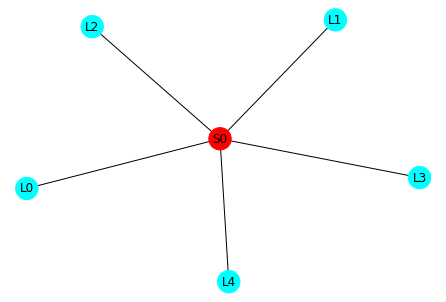

In [14]:
nviz.plot_soma_limb_concept_network(neuron_obj)

In [15]:
nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


# Sending the data to the Neuron Object

In [16]:
nru = reload(nru)
save_time = time.time()
neuron_obj.save_compressed_neuron(output_folder="/notebooks/test_neurons/Fusion_decomp/",
                                 export_mesh=True,
                                 suppress_output=True)
print(f"Save time = {time.time() - save_time}")

Saving Neuorn in suppress_output mode...please wait
Saved File at location: /notebooks/test_neurons/Fusion_decomp/864691135579649476_large_axon_cloud_2
Save time = 133.3716595172882


In [17]:
nru = reload(nru)
reload_time = time.time()
recovered_neuron = nru.decompress_neuron(filepath="./12345_double_soma",
                     original_mesh="./12345_double_soma")
print(f"Save time = {time.time() - reload_time}")

Decompressing Neuron in minimal output mode...please wait
Save time = 64.5683376789093


In [18]:
import neuron_visualizations as nviz
returned_colors = nviz.visualize_neuron(recovered_neuron,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L6="all"),
                                       return_color_dict=True)


 Working on visualization type: mesh

 Working on visualization type: skeleton
